In [1]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.ticker as mtick
from matplotlib import pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_regression

In [2]:
pickle_off = open ("return_1d.pkl", "rb")
return_1d = pickle.load(pickle_off)
return_1d.head()

,Nifty_50_1d_return,Dow_Jons_1d_return,SPX_500_1d_return,NASDAQ_1d_return,BRENT_1d_return,BOND_10Y_1d_return,Gold_1d_return,Inr_Usd_1d_return,Dollar_Index_1d_return,Bank_Nifty_1d_return,Nifty_IT_1d_return,Nifty_Auto_1d_return,Nifty_Metal_1d_return,Nifty_FMGC_1d_return,Nifty_Energy_1d_return,NIFTY_FIN_SERVICE_1d_return,Nifty_Infra_1d_return,Nifty_CMDT_1d_return,Nifty_Consumer_1d_return
Date,,,,,,,,,,,,,,,,,,,
08-09-11,-0.53,-1.42,-1.37,-1.26,-1.42,-1.81,-1.74,-1.00,-2.71,-0.70,8.26,0.42,-1.46,-0.27,-0.34,-1.00,-0.83,-0.81,-1.19
13-09-11,-0.95,-0.36,0.31,0.35,-0.30,1.97,-1.37,0.01,-2.73,-0.80,-1.27,1.72,0.03,-0.86,-1.16,0.42,-0.88,-0.26,0.88
14-09-11,-13.25,2.14,0.48,0.07,-2.42,-0.68,-1.19,-0.43,-0.88,-3.40,3.66,-0.71,-1.07,-91.91,3.21,-0.79,0.02,-1.14,-0.63
15-09-11,-0.13,0.31,0.28,-0.16,4.74,2.96,12.66,-0.67,6.38,0.40,-0.46,-5.15,8.29,-1.20,-0.03,-2.90,-2.51,5.99,-3.54
16-09-11,-0.87,-0.60,-0.67,-0.56,-2.03,-1.12,-1.77,-1.60,-1.58,-0.69,-1.44,-0.69,-0.91,3.86,-0.64,1.62,0.43,-0.60,-1.61


In [3]:
# Add lagged returns as features
return_1d['Nifty_FMGC_1d_return'] = return_1d['Nifty_FMGC_1d_return'].shift(1)
return_1d['Nifty_50_1d_return_lag1'] = return_1d['Nifty_50_1d_return'].shift(1)
return_1d = return_1d.dropna()
return_1d['return_squared'] = return_1d['Nifty_FMGC_1d_return'] ** 2
return_1d['return_lag_interaction'] = return_1d['Nifty_FMGC_1d_return'] * return_1d['Nifty_50_1d_return_lag1']
# Detect and remove outliers using IQR
q1 = return_1d['Nifty_FMGC_1d_return'].quantile(0.25)
q3 = return_1d['Nifty_FMGC_1d_return'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5*iqr
upper_bound = q3 + 1.5*iqr
return_1d = return_1d[(return_1d['Nifty_FMGC_1d_return'] >= lower_bound) & (return_1d['Nifty_FMGC_1d_return'] <= upper_bound)]
np.random.seed(42)

In [4]:
# Display the cleaned data
print("Cleaned data:")
print(return_1d.head())

Cleaned data:
          Nifty_50_1d_return  Dow_Jons_1d_return  SPX_500_1d_return  \
Date                                                                  
13-09-11               -0.95               -0.36               0.31   
14-09-11              -13.25                2.14               0.48   
16-09-11               -0.87               -0.60              -0.67   
20-09-11               -3.09               -1.07              -0.83   
21-09-11               -1.06              -38.08              16.69   

          NASDAQ_1d_return  BRENT_1d_return  BOND_10Y_1d_return  \
Date                                                              
13-09-11              0.35            -0.30                1.97   
14-09-11              0.07            -2.42               -0.68   
16-09-11             -0.56            -2.03               -1.12   
20-09-11              1.39            -1.47               -1.08   
21-09-11              1.32            -1.13               -7.96   

          Gold_1d_

In [5]:
# Display the statistics of the cleaned data
print("Statistics of the cleaned data:")
print(return_1d.describe())

Statistics of the cleaned data:
       Nifty_50_1d_return  Dow_Jons_1d_return  SPX_500_1d_return  \
count         1768.000000         1768.000000        1768.000000   
mean            -1.496951           -4.317919           0.092460   
std             75.190858          111.310093          39.886683   
min          -2807.010000        -3606.010000        -363.000000   
25%             -1.902500           -1.900000          -2.000000   
50%             -0.880000           -1.000000          -1.000000   
75%              0.240000           -0.030000          -0.100000   
max            904.410000          569.550000        1128.740000   

       NASDAQ_1d_return  BRENT_1d_return  BOND_10Y_1d_return  Gold_1d_return  \
count       1768.000000      1768.000000         1768.000000     1768.000000   
mean          -2.680119        -2.175515           -0.992534       -0.716934   
std           66.519013        22.976139            2.308015       12.982221   
min        -1517.720000      -426.1

In [6]:
# Correlation analysis
corr_matrix_1d = return_1d.corr()
nifty_corr_1d = pd.DataFrame(return_1d.corr()['Nifty_FMGC_1d_return'].sort_values())
nifty_corr_1d

,Nifty_FMGC_1d_return
return_squared,-0.673934
Dow_Jons_1d_return,-0.029322
Gold_1d_return,-0.025819
Inr_Usd_1d_return,-0.023365
BRENT_1d_return,-0.022191
NASDAQ_1d_return,-0.021981
Nifty_50_1d_return_lag1,-0.018539
BOND_10Y_1d_return,-0.009676
Nifty_Metal_1d_return,-0.002300
Nifty_IT_1d_return,0.000440


<Axes: >

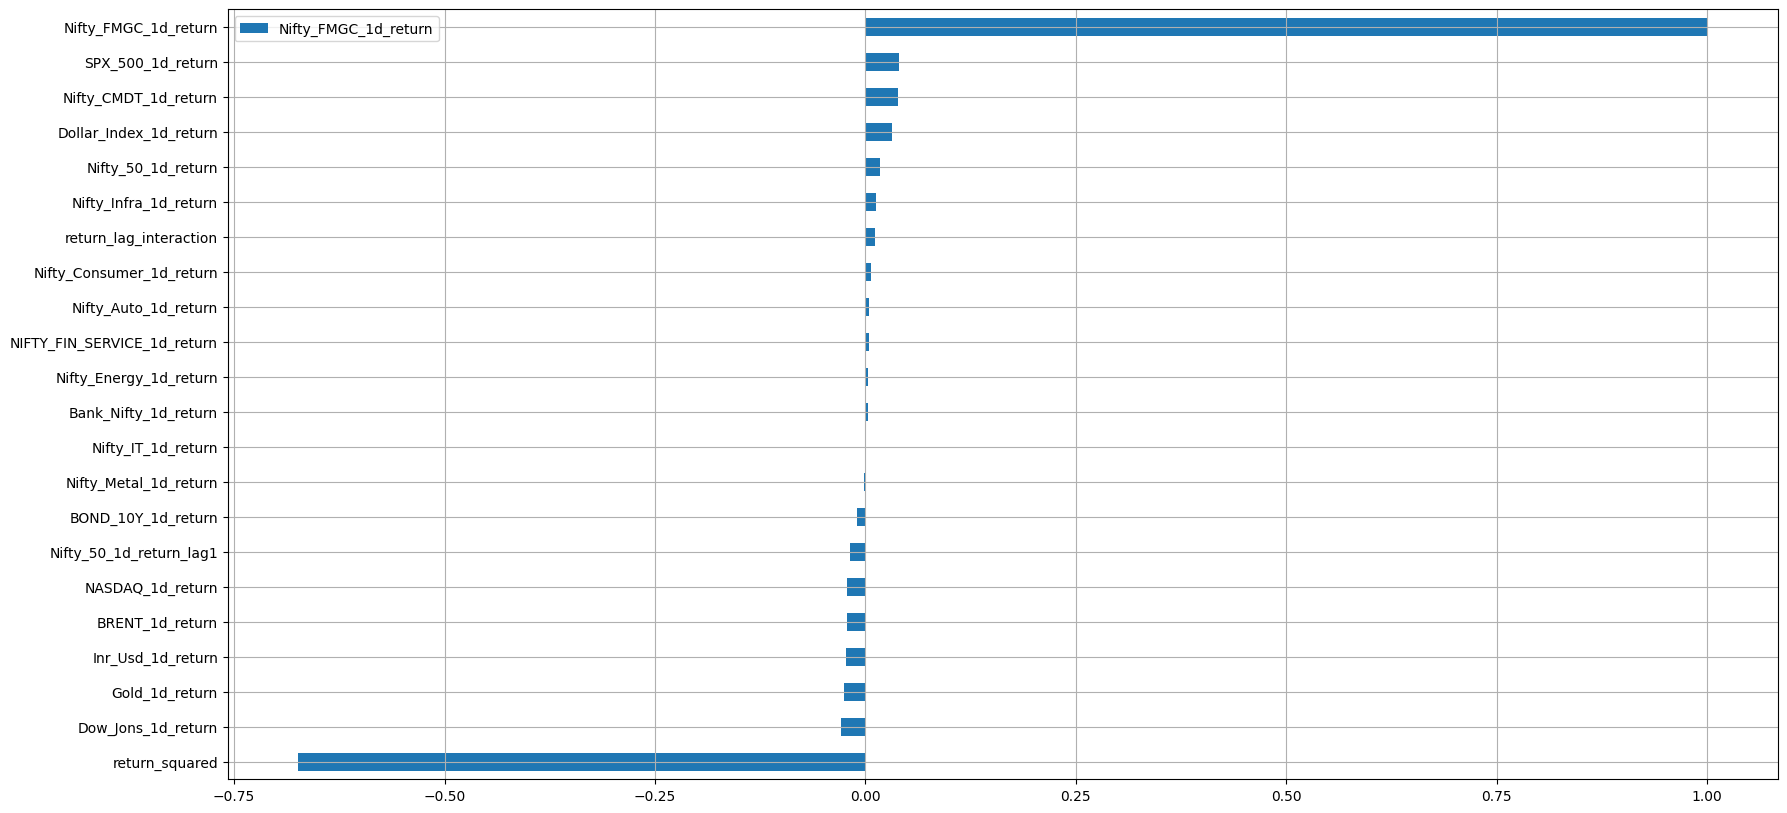

In [7]:
filter = np.abs(nifty_corr_1d)  # this creates a float64 array
mask = filter >= -1  # this creates a boolean mask based on the condition
nifty_corr_1d[mask].plot.barh(figsize=(20,10), grid=True)  # use the boolean mask to index the DataFrame

In [8]:
# Feature selection using mutual information
selector = SelectKBest(score_func=mutual_info_regression, k='all')
X = return_1d.drop(columns='Nifty_FMGC_1d_return')
y = return_1d['Nifty_FMGC_1d_return']
X_new = selector.fit_transform(X, y)
print('Selected features:', X.columns[selector.get_support()])

Selected features: Index(['Nifty_50_1d_return', 'Dow_Jons_1d_return', 'SPX_500_1d_return',
       'NASDAQ_1d_return', 'BRENT_1d_return', 'BOND_10Y_1d_return',
       'Gold_1d_return', 'Inr_Usd_1d_return', 'Dollar_Index_1d_return',
       'Bank_Nifty_1d_return', 'Nifty_IT_1d_return', 'Nifty_Auto_1d_return',
       'Nifty_Metal_1d_return', 'Nifty_Energy_1d_return',
       'NIFTY_FIN_SERVICE_1d_return', 'Nifty_Infra_1d_return',
       'Nifty_CMDT_1d_return', 'Nifty_Consumer_1d_return',
       'Nifty_50_1d_return_lag1', 'return_squared', 'return_lag_interaction'],
      dtype='object')


In [9]:
# Feature Scaling
scaler = StandardScaler()
X = return_1d.drop(columns='Nifty_FMGC_1d_return')
y = return_1d['Nifty_FMGC_1d_return']
X = scaler.fit_transform(X_new)
y = y.astype('float32')
print(X[-5:])
print(y[-5:])

[[-3.96281326e+00  5.65060850e-02 -3.82341999e-03 -1.57876404e-02
   1.33894772e-01 -1.08239007e+00 -4.87778417e-02  6.57916726e-02
   2.85118788e+00 -2.96536113e-01  1.31896464e-02 -2.78631168e-02
  -2.26230677e-02  4.81562240e+00 -1.11966793e-01 -6.95020412e-02
  -5.06148962e-02  8.36246894e-02 -2.86180805e-02  2.28138457e+00
   5.62439297e-02]
 [ 9.53778457e-03 -1.67335076e-02 -4.93097491e-01  1.27069076e-01
  -2.76227792e-02  1.04991484e+00  1.74853436e-02  3.82018543e-01
  -1.18491058e-01 -1.20744305e-02 -1.28147712e-02 -7.10930019e-02
   2.49987727e-02  3.71932173e-01 -3.83143826e-02  8.76594741e-02
  -2.77451304e-02 -6.70312481e-03 -8.98827126e+00 -6.79638014e-01
   1.32221192e+00]
 [ 2.93596300e-02  3.58372430e-02 -2.13781022e-02  2.16558568e-02
   1.21269411e-01 -1.15918537e-01 -1.52025131e-01 -1.39666464e-01
  -7.86377010e-02  2.68335091e-01 -7.30472257e-02  9.58849900e-02
  -3.32679497e-02  1.20820247e-02 -5.20597779e-02  3.97995888e-02
  -4.58002086e-02  2.22969573e-04 -1.9

Data Cleaning And Transformation Completed

Model Building for Features Importance

In [10]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Define regression models
dtr = DecisionTreeRegressor(max_depth=5)
rfr = RandomForestRegressor(n_estimators=50, random_state=2)
etr = ExtraTreesRegressor(n_estimators=50, random_state=2)
gbr = GradientBoostingRegressor(n_estimators=50, random_state=2)
xgbr = XGBRegressor(n_estimators=50, random_state=2)

In [12]:
regressors = {
    'DTR': dtr,
    'RFR': rfr,
    'ETR': etr,
    'GBR': gbr,
    'XGBR': xgbr
}

In [13]:
def train_regressor(regressor, X_train, y_train, X_test, y_test):
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

In [14]:
mse_scores = []
r2_scores = []
for name, regressor in regressors.items():
    current_mse, current_r2 = train_regressor(regressor, X_train, y_train, X_test, y_test)
    print(f"For {name}:")
    print(f"MSE: {current_mse:.4f}")
    print(f"R2: {current_r2:.4f}\n")
    mse_scores.append(current_mse)
    r2_scores.append(current_r2)

For DTR:
MSE: 0.7799
R2: 0.5335

For RFR:
MSE: 0.3837
R2: 0.7705

For ETR:
MSE: 0.7463
R2: 0.5536

For GBR:
MSE: 0.5830
R2: 0.6513

For XGBR:
MSE: 0.2761
R2: 0.8349



In [15]:
scaler = StandardScaler()
# Find the index of the model with the lowest MSE score
best_model_index = np.argmin(mse_scores)
# Get the name of the best model
best_model_name = list(regressors.keys())[best_model_index]
# Print the name of the best model
print(f"The best model is {best_model_name} with an MSE of {mse_scores[best_model_index]:.4f}.")
# Train the best model on the full dataset
best_model = regressors[best_model_name]
best_model.fit(scaler.fit_transform(X), y)

The best model is XGBR with an MSE of 0.2761.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=50, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=2, ...)

The best model is XGBR with an MSE of 0.2761.

In [16]:
y_pred = gbr.predict(X_test)
df_1d = pd.DataFrame({'Actual': y_test, 'Predicted':y_pred})
df_1d

,Actual,Predicted
Date,,
17-09-18,-0.80,-0.543400
07-05-13,0.47,0.303470
04-03-14,-0.61,-0.862303
13-08-18,0.26,0.484366
14-10-14,-0.73,-0.818252
...,...,...
29-05-20,1.28,-0.270389
06-11-12,0.89,0.103617
18-10-11,-0.57,-0.588583


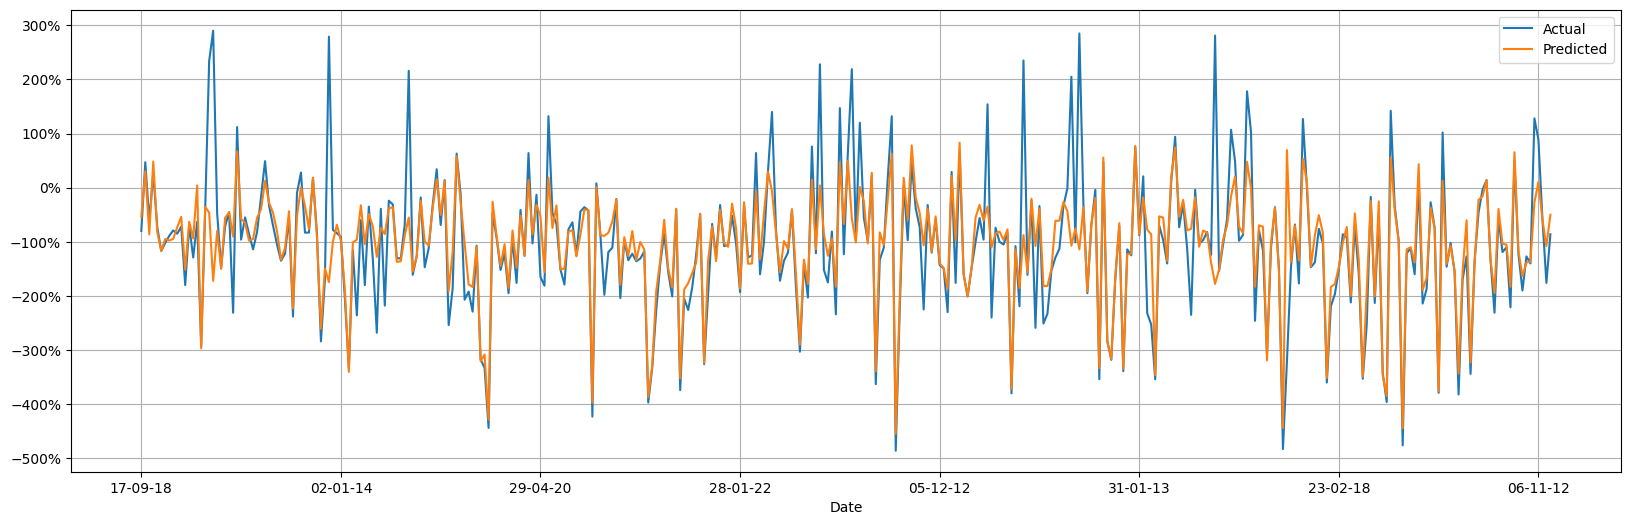

In [17]:
ax = df_1d.plot(figsize=(20,6), grid=True)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))

C:\Users\Harsh\AppData\Local\Temp\ipykernel_15892\3094767840.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test-y_pred)


<Axes: xlabel='Nifty_FMGC_1d_return', ylabel='Density'>

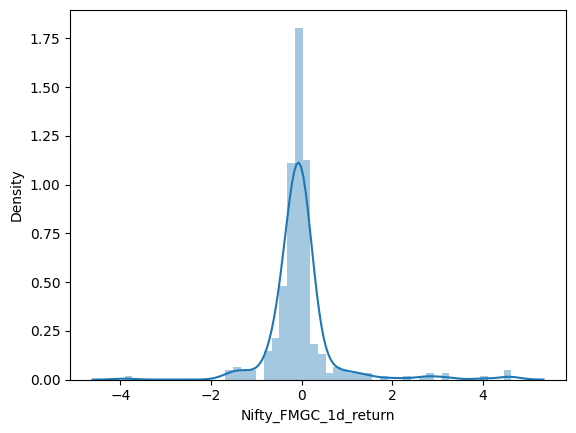

In [18]:
sns.distplot(y_test-y_pred)

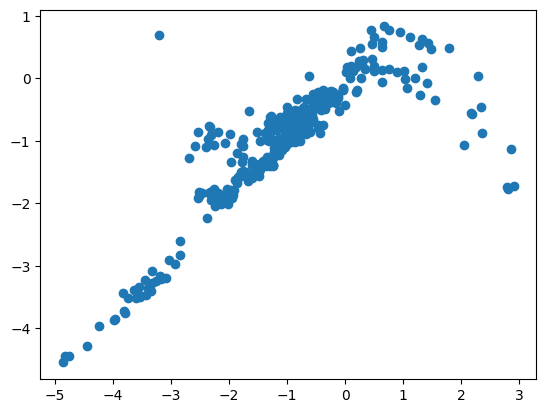

In [19]:
plt.scatter(y_test,y_pred)
